In [1]:
%pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python nomic[local]

下载ollama

In [2]:
! sudo apt-get install -y pciutils
! curl https://ollama.ai/install.sh | sh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpci3 pci.ids
The following NEW packages will be installed:
  libpci3 pci.ids pciutils
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 343 kB of archives.
After this operation, 1,581 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pci.ids all 0.0~2022.01.22-1 [251 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpci3 amd64 1:3.7.0-6 [28.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 pciutils amd64 1:3.7.0-6 [63.6 kB]
Fetched 343 kB in 2s (199 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initializ

后台运行不打印日志，如果需要打印日志可以添加配置文件启动

In [11]:
! nohup ollama serve >/dev/null 2>&1 &


In [12]:
! ollama --version


ollama version is 0.3.8


拉取模型

In [13]:
! ollama pull mistral

pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠇ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠧ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠹ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠴ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠇ pulling manifest 
pulling ff82381e2bea...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕▏    0 B/4.1 GB

配置 langsmith （非必须）

In [14]:
import os
from google.colab import userdata
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

In [28]:
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

拉取解析文章，创建检索器

In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    # 拉取量化模型到本地
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
)
retriever = vectorstore.as_retriever()

Downloading: 100%|██████████| 274M/274M [00:04<00:00, 66.7MiB/s]
Verifying: 100%|██████████| 274M/274M [00:00<00:00, 515MiB/s]


In [20]:
# Ollama model name
local_llm = "mistral"

使用联网工具还是RAG检索路由节点

In [21]:
### Router
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)
prompt = PromptTemplate(
    template="""You are an expert at routing a user question to a vectorstore or web search. """
    """Use the vectorstore for questions on LLM  agents, prompt engineering, and adversarial attacks. """
    """You do not need to be stringent with the keywords in the question related to these topics. """
    """Otherwise, use web-search. Give a binary choice 'web_search' or 'vectorstore' based on the question. """
    """Return the a JSON with a single key 'datasource' and no premable or explanation. """
    """Question to route: {question}""",
    input_variables=["question"],
)
question_router = prompt | llm | JsonOutputParser()
question = "llm agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(


{'datasource': 'vectorstore'}


文章片段评估节点

In [22]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


根据文章片段生成答案节点

In [23]:
### Generate

from langchain import hub
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOllama(model=local_llm, temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "agent memory"
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


1. In an LLM-powered autonomous agent system, the memory stream serves as the long-term memory module, recording comprehensive experiences in natural language.
2. The design of generative agents combines LLM with memory, planning and reflection mechanisms to enable agents to behave conditioned on past experience.
3. Short-term memory in these agents utilizes in-context learning, while long-term memory provides the capability to retain and recall information over extended periods by leveraging an external vector store and fast retrieval.


模型幻觉评估节点

In [24]:
### Hallucination Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n
    Here are the facts:
    \n ------- \n
    {documents}
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

生成答案评估节点

In [25]:
### Answer Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is useful to resolve a question. \n
    Here is the answer:
    \n ------- \n
    {generation}
    \n ------- \n
    Here is the question: {question}
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

问题重写节点

In [26]:
### Question Re-writer

# LLM
llm = ChatOllama(model=local_llm, temperature=0)

# Prompt
re_write_prompt = PromptTemplate(
    template="""You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the initial and formulate an improved question. \n
     Here is the initial question: \n\n {question}. Improved question with no preamble: \n """,
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

" What is the function of an agent's memory in a given context?"

联网查询工具

In [29]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# 构建graph工作流

In [30]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

定义封装节点

In [31]:
### Nodes

from langchain.schema import Document

### 检索器
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

### 生成答案
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

### 文章片段相关性评估
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

### 重新表述问题
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

### 联网查询
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###

### web search 或 RAG 路由
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])
    if source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

### 生成回答或重写问题路由
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### 采用答案或重新回答
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [32]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

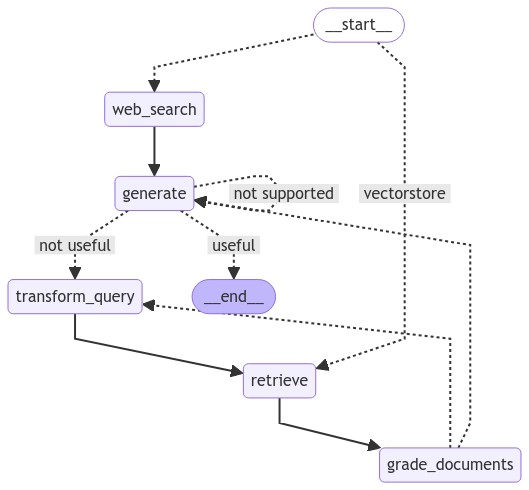

In [36]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [33]:
from pprint import pprint

# Run
inputs = {"question": "What is the AlphaCodium paper about?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
What is the AlphaCodium paper about?
{'datasource': 'web_search'}
web_search
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
(' The AlphaCodium paper presents a new approach to code generation by Large '
 'Language Models (LLMs). It proposes a test-based, multi-stage, iterative '
 'flow called AlphaCodium that improves LLM performance on code problems. This '
 'method was tested on the CodeContests dataset and demonstrated better '
 "results than DeepMind's AlphaCode and AlphaCode2 without fine-tuning a "
 'model. The full implementation is available at '
 'https://github.com/Codium-ai/AlphaCodium.')
